In [1]:
! nvidia-smi

Fri Jun 14 18:12:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.83                 Driver Version: 546.83       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4080 ...  WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   39C    P8               8W /  45W |    558MiB / 12282MiB |     11%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# %load_ext autoreload
# %autoreload 2

# Import the relevant modules

# Import the mathematical libraries
import math
import numpy as np
import pandas as pd

# Import the input output libraries
import os
import sys
import h5py

# Import the plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import the machine learning libraries
from sklearn.model_selection import train_test_split
import pytorch_lightning as pL
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor
from torchvision.transforms import v2
import torchsummary
torch.set_float32_matmul_precision('medium')
from tifffile import imread, imsave

import warnings
warnings.filterwarnings('ignore')

from tifffile import imread




if not torch.cuda.is_available():
    raise ValueError("GPU not found, code will run on CPU and can be extremely slow!")
else:
    device = torch.device("cuda:0")

import time
from glob import glob
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
import torch.optim as optim
import torch.utils.data as dt


import sys
sys.path.append('../../gap/')
from GAP_UNET_ResBlock import UN
from BinomDataset import BinomDataset
from Inference import sample_image

In [3]:
Dataset = np.concatenate((imread(r'trainingDataGT.tif'), imread(r'testDataGT.tif')))
Dataset[0]

array([[30, 42, 33, ...,  3,  4,  3],
       [35, 32, 37, ...,  4,  4,  5],
       [38, 52, 38, ...,  4,  3,  1],
       ...,
       [ 8,  5,  4, ..., 47, 63, 72],
       [ 2,  3,  6, ..., 57, 57, 62],
       [ 7,  6,  4, ..., 65, 52, 51]], dtype=int16)

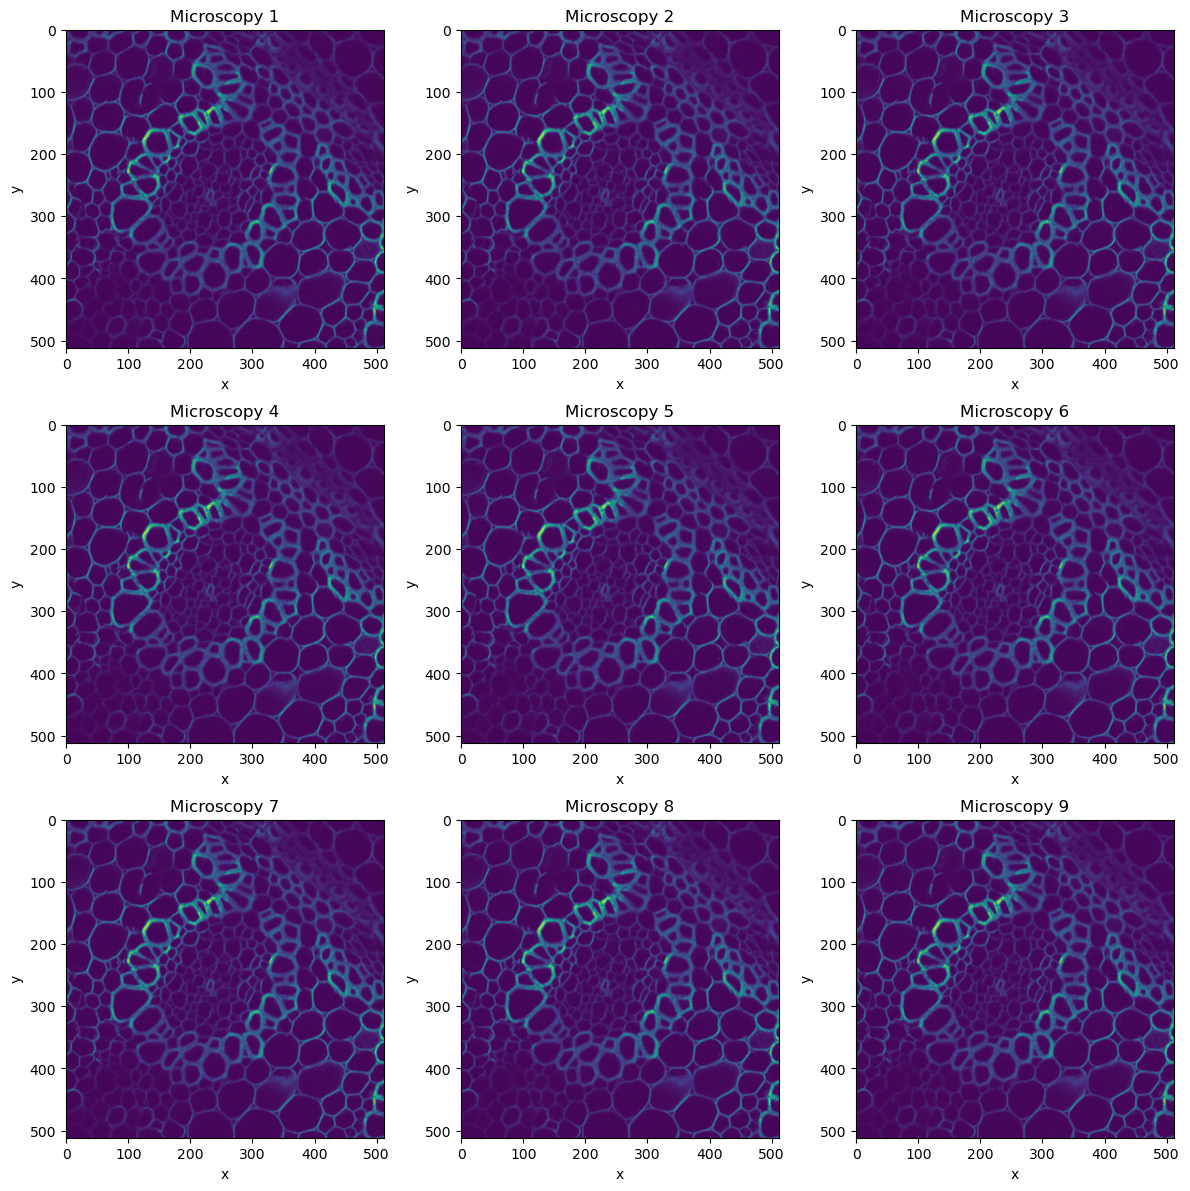

In [5]:
Figure = plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(Dataset[i])
    plt.title(f'Microscopy {i + 1}')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.tight_layout()
plt.show()

(array([16384.,     0., 16365.,    19.,     0.,     0.,     0.,     0.,
            0., 16384.]),
 array([-2.11750412, -2.0837431 , -2.04998207, -2.01622105, -1.98246002,
        -1.948699  , -1.91493809, -1.88117707, -1.84741604, -1.81365502,
        -1.77989399]),
 <BarContainer object of 10 artists>)

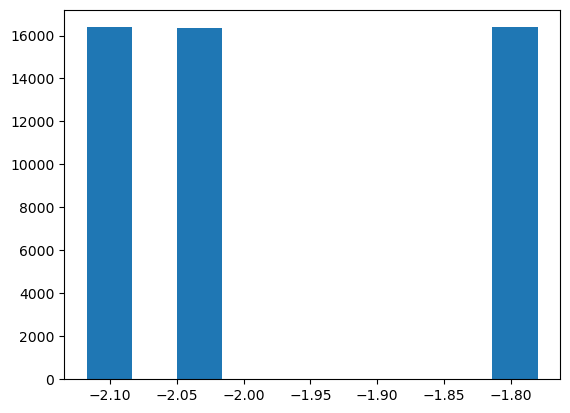

In [128]:
transforms = v2.Compose([
    v2.ToTensor(),
    v2.Resize((128,128)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ConvertImageDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


element = transforms(Dataset[0])
plt.hist(element.reshape(-1,))

In [6]:
Train_Validation_Images_Dataset, Test_Images_Dataset = Dataset[:int(len(Dataset) * 0.8)], Dataset[int(len(Dataset) * 0.8):]
Train_Validation_Images_Dataset.shape, Test_Images_Dataset.shape

((1638, 512, 512), (410, 512, 512))

In [158]:
from skimage.transform import resize
from tqdm import tqdm # progress which the model
import matplotlib.pyplot as plt
%matplotlib inline
          

ORIG_SHAPE = (512,512)
CROP_SIZE = (256,256)
IMG_SHAPE = (128,128)

def get_image(image, x1,y1, shape, crop_size):
    x = image
    x = x[x1:x1+crop_size[0], y1:y1+crop_size[1]]
    x = resize(x, shape)
    min = x.min()
    max = x.max()
    x = (x - min) / (max - min)
    return x
    
def get_all_images(image_dataset, shape=IMG_SHAPE, crop_size=CROP_SIZE):
    x1 = (ORIG_SHAPE[0]-CROP_SIZE[0])//2
    y1 = (ORIG_SHAPE[1]-CROP_SIZE[1])//2
   
    sel = image_dataset
    #y_batch = labels[:len(sel)]
    x_batch = []
    for index in tqdm(range(image_dataset.shape[0])):
        x = get_image(image_dataset[index], x1, y1, shape, crop_size)
        x_batch.append(x)
    x_batch = np.array(x_batch)
    return x_batch #y_batch
        
X_train = get_all_images(Train_Validation_Images_Dataset)
X_Valid = get_all_images(Test_Images_Dataset)
X_train.shape, X_Valid.shape

100%|██████████| 410/410 [00:00<00:00, 460.36it/s]


((1638, 128, 128), (410, 128, 128))

In [159]:
X_train[0].max()

1.0

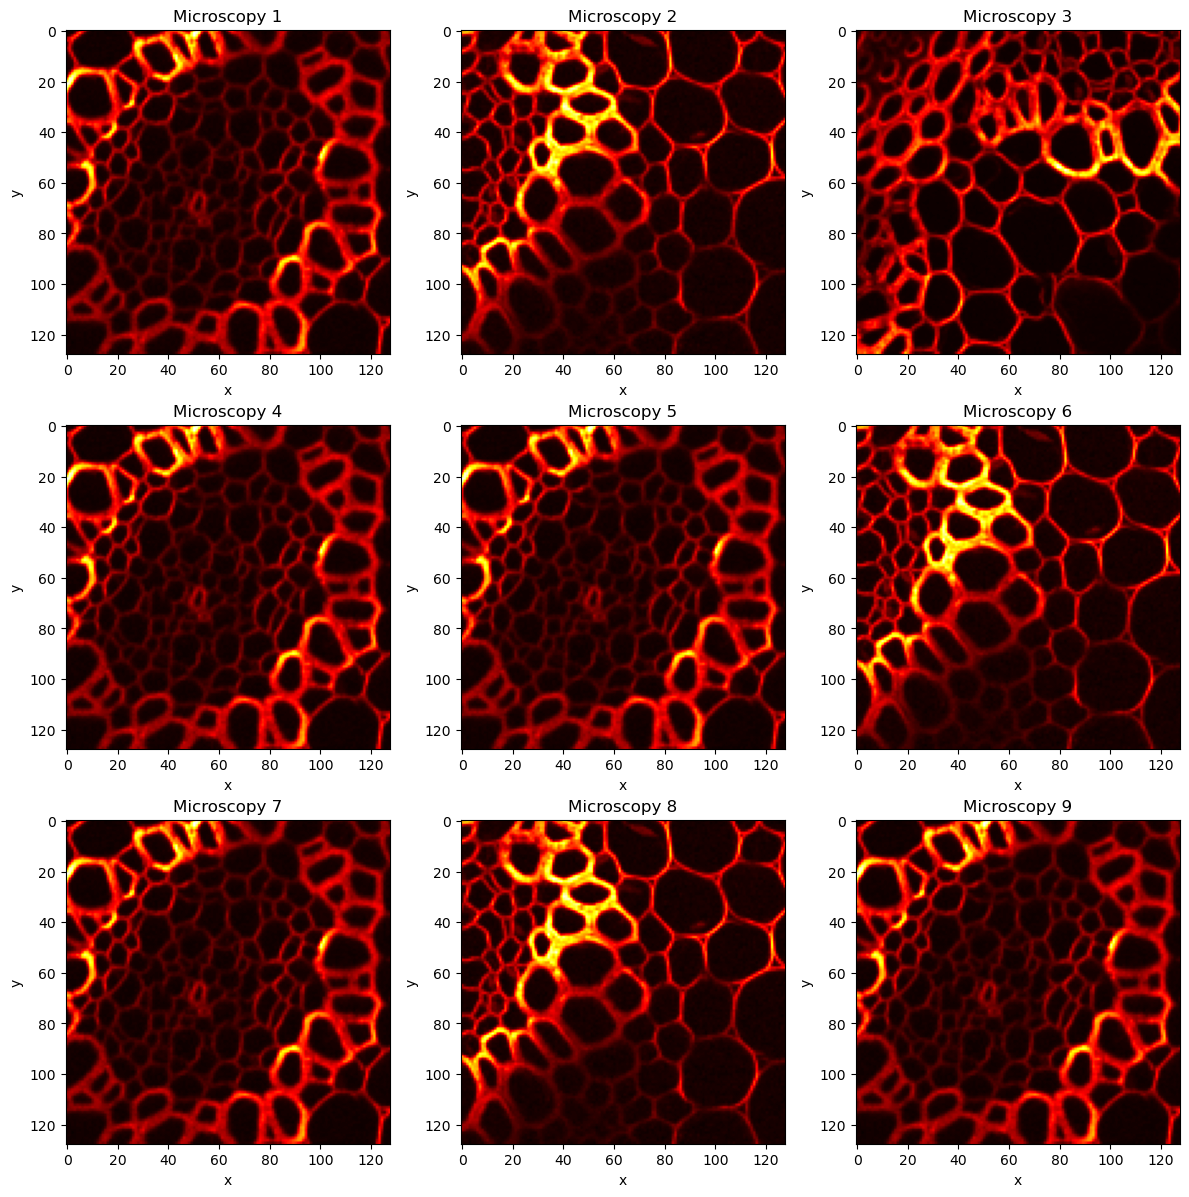

In [160]:
indices = np.random.choice(X_train.shape[0], 9)
Sample = X_train[indices]
Figure = plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(Sample[i], cmap = "hot")
    plt.title(f'Microscopy {i + 1}')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.tight_layout()
plt.show()

In [251]:
from torchmetrics import StructuralSimilarityIndexMeasure
def MSLE_Loss(y_pred, y_true):
    eps = torch.FloatTensor([1e-6]).to(device)
    mse = F.mse_loss(torch.log1p(torch.maximum(y_pred, eps)), torch.log1p(torch.maximum(y_true, eps)), reduction = 'mean')
    #ssim = StructuralSimilarityIndexMeasure(data_range = 1.0, reduction = 'mean')(y_pred, y_true)
    return mse

In [371]:
class GaussianNoise(nn.Module):
    def __init__(self, stddev):
        super(GaussianNoise, self).__init__()
        self.stddev = stddev
    
    def forward(self, x):
        if self.training:
            noise = torch.randn_like(x) * self.stddev
            return x + noise
        return x
    
class Encoder(nn.Module):
    def __init__(self, dropout_rate = 0.2):
        super(Encoder, self).__init__()

        self.GaussianNoise = GaussianNoise(0.1)
        #self.BatchNorm0 = nn.BatchNorm2d(3)
        self.conv1a = nn.Conv2d(1, 8, 3, padding = 1) # 64 x 64
        self.conv1b = nn.Conv2d(8, 16, 3, padding = 1)
        self.conv1c = nn.Conv2d(1, 16, 1)

        self.MaxPool1 = nn.MaxPool2d(2, 2)
        self.BatchNorm1 = nn.BatchNorm2d(16)
        self.dropout = nn.Dropout(dropout_rate)
        self.activation = nn.LeakyReLU()

        self.conv2a = nn.Conv2d(16, 32, 3, padding = 1) # 32 x 32
        self.conv2b = nn.Conv2d(32, 64, 3, padding = 1) # 16 x 16
        self.conv2c = nn.Conv2d(16, 64, 1)

        self.MaxPool2 = nn.MaxPool2d(2, 2)
        self.BatchNorm2 = nn.BatchNorm2d(64)
        self.dropout_2 = nn.Dropout(dropout_rate)
        self.activation_2 = nn.LeakyReLU()

        self.conv3a = nn.Conv2d(64, 128, 3, padding = 1) # 16 x 16
        self.conv3b = nn.Conv2d(128, 128, 3, padding = 1)
        self.conv3c = nn.Conv2d(64, 128, 1)

        self.MaxPool3 = nn.MaxPool2d(2, 2)
        self.BatchNorm3 = nn.BatchNorm2d(128)
        self.dropout_3 = nn.Dropout(dropout_rate)
        self.activation_3 = nn.LeakyReLU()

        self.conv4a = nn.Conv2d(128, 256, 3, padding = 1) # 8 x 8
        self.conv4b = nn.Conv2d(256, 256, 3, padding = 1)
        self.conv4c = nn.Conv2d(128, 256, 1)
        self.MaxPool4 = nn.MaxPool2d(2, 2)
        self.BatchNorm4 = nn.BatchNorm2d(256)
        self.dropout_4 = nn.Dropout(dropout_rate)
        self.activation_4 = nn.LeakyReLU()

        self.conv4a = nn.Conv2d(128, 256, 3, padding = 1) # 8 x 8
        self.conv4b = nn.Conv2d(256, 256, 3, padding = 1)
        self.conv4c = nn.Conv2d(128, 256, 1)
        self.MaxPool4 = nn.MaxPool2d(2, 2)
        self.BatchNorm4 = nn.BatchNorm2d(256)
        self.dropout_4 = nn.Dropout(dropout_rate)
        self.activation_4 = nn.LeakyReLU()


    def forward(self, x):
        x = self.GaussianNoise(x)
        x_skip = x
        x = self.BatchNorm1(self.activation(self.conv1b(self.conv1a(x_skip))))
        x_skip = self.conv1c(x_skip)
        x = torch.add(x, x_skip)
        #x = self.dropout(x)
        x = self.MaxPool1(x)

        x_skip = x
        x = self.BatchNorm2(self.activation_2(self.conv2b(self.conv2a(x))))
        x_skip = self.conv2c(x_skip)
        x = torch.add(x, x_skip)
        #x = self.dropout_2(x)
        x = self.MaxPool2(x)

        x_skip = x
        x = self.BatchNorm3(self.activation_3(self.conv3b(self.conv3a(x))))
        x_skip = self.conv3c(x_skip)
        x = torch.add(x, x_skip)
        x = self.dropout_3(self.MaxPool3(x))

        x_skip = x
        x = self.BatchNorm4(self.activation_4(self.conv4b(self.conv4a(x))))
        x_skip = self.conv4c(x_skip)
        x = torch.add(x, x_skip)
        #x = self.dropout_4(x)
        x = self.MaxPool4(x)

        return x
    
    def weights_init(self, m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.GroupNorm):
            torch.nn.init.zeros_(m.weight)
            torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.BatchNorm2d):
            torch.nn.init.zeros_(m.weight)
            torch.nn.init.zeros_(m.bias)

In [372]:
class Decoder(nn.Module):
    def __init__(self, dropout_rate = 0.2):
        super(Decoder, self).__init__()
    
        self.TransConv1a = nn.ConvTranspose2d(256, 128, 3, stride = 2, padding= 1, output_padding= 1) # 4 x 4
        self.Conv1b = nn.Conv2d(128, 64, 3, stride = 1, padding = 1) 
        self.Conv1c = nn.Conv2d(128, 64, 1, stride = 1, padding = 0)
        self.Conv1d = nn.Conv2d(64, 64, 3, stride = 1, padding = 1)
        self.Batchnorm1 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.activation1 = nn.LeakyReLU()

        self.TransConv2a = nn.ConvTranspose2d(64, 32, 2, stride = 2, padding= 0, output_padding= 0) # 8 x 8
        self.Conv2b = nn.Conv2d(32, 16, 3, stride = 1, padding = 1) 
        self.Conv2c = nn.Conv2d(32, 16, 1, stride = 1, padding = 0)
        self.Conv2d = nn.Conv2d(16, 16, 3, stride = 1, padding = 1)
        self.Batchnorm2 = nn.BatchNorm2d(16)
        #self.dropout2 = nn.Dropout(dropout_rate)
        self.activation2 = nn.LeakyReLU()

        self.TransConv3a = nn.ConvTranspose2d(16, 8, 3, stride = 2, padding= 1, output_padding= 1) # 16 x 16
        self.Conv3b = nn.Conv2d(8, 4, 3, stride = 1, padding = 1)
        self.Conv3c = nn.Conv2d(8, 4, 1, stride = 1, padding = 0) 
        self.Conv3d = nn.Conv2d(4, 4, 3, stride = 1, padding = 1)
        self.Batchnorm3 = nn.BatchNorm2d(4)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.activation3 = nn.LeakyReLU()

        self.TransConv4a = nn.ConvTranspose2d(4, 3, 2, stride = 2, padding= 0, output_padding= 0) # 32 x 32
        self.Conv4b = nn.Conv2d(3, 1, 3, stride = 1, padding = 1) 
        self.Conv4c = nn.Conv2d(3, 1, 1, stride = 1, padding = 0)
        self.Conv4d = nn.Conv2d(1, 1, 3, stride = 1, padding = 1)
        self.Batchnorm4 = nn.BatchNorm2d(1)
        #self.dropout4 = nn.Dropout(dropout_rate)
        self.activation4 = nn.LeakyReLU()

    
    def forward(self, x):
        # x 4 x 4
        x_skip = self.TransConv1a(x)
        x = self.activation1(self.Batchnorm1(self.Conv1b(x_skip)))
        x_skip = self.Conv1c(x_skip)
        x = torch.add(x, x_skip)
        x = self.Conv1d(x)
        #x = self.dropout1(x)

        x_skip = self.TransConv2a(x)
        x = self.activation2(self.Batchnorm2(self.Conv2b(x_skip)))
        x_skip = self.Conv2c(x_skip)
        x = torch.add(x, x_skip)
        x = self.Conv2d(x)
        # x = self.dropout2(x)

        x_skip = self.TransConv3a(x)
        x = self.activation3(self.Batchnorm3(self.Conv3b(x_skip)))
        x_skip = self.Conv3c(x_skip)
        x = torch.add(x, x_skip)
        x = self.Conv3d(x)
        #x = self.dropout3(x)

        x_skip = self.TransConv4a(x)
        x = self.activation4(self.Batchnorm4(self.Conv4b(x_skip)))
        x_skip = self.Conv4c(x_skip)
        x = torch.add(x, x_skip)
        x = self.Conv4d(x)
        #x = self.dropout4(x)
        
        x = F.sigmoid(x)
        return x
    
    def weights_init(self, m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.GroupNorm):
            torch.nn.init.zeros_(m.weight)
            torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.BatchNorm2d):
            torch.nn.init.zeros_(m.weight)
            torch.nn.init.zeros_(m.bias)

In [373]:
class Convolutional_AE(pL.LightningModule):
    def __init__(self, learning_rate, dropout_rate, weight_decay):
        super(Convolutional_AE, self).__init__()
        
        self.encoder = Encoder(dropout_rate)
        self.decoder = Decoder(dropout_rate)
        
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def latent_space(self, x):
        x = self.encoder(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        
        x = self.encoder(x)
        x = self.decoder(x)
        
        loss = F.mse_loss(x, y)
        self.log("Training_Loss", loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        
        x = self.encoder(x)
        x = self.decoder(x)
        
        loss = F.mse_loss(x, y)
        self.log("Validation_Loss", loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.NAdam(self.parameters(), lr = self.learning_rate, weight_decay=self.weight_decay)
        scheduler = {
            "scheduler":ReduceLROnPlateau(optimizer, mode = "min", factor = 0.5, patience = 10, verbose = True),
            "monitor":"Validation_Loss"
        }
        
        return [optimizer], [scheduler]
    
    def predict_step(self, batch, batch_idx):
        x, y = batch
        ReconstructedImage = self.forward(x)
        return ReconstructedImage
    
    def latent_space_step(self, batch, batch_idx):
        x, y = batch
        LatentSpace = self.latent_space(x)
        return LatentSpace
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        
        x = self.encoder(x)
        x = self.decoder(x)
        
        loss = F.mse_loss(x, y)
        self.log("Test_Loss", loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        return loss

In [374]:
X_trainer = np.expand_dims(X_train, axis = -1)
X_Valider = np.expand_dims(X_Valid, axis = -1)

In [375]:
X_Train_Tensor = torch.tensor(X_trainer).float().permute(0, 3, 1, 2).to(device)
X_Valid_Tensor = torch.tensor(X_Valider).float().permute(0, 3, 1, 2).to(device)
X_Train_Dataloder = DataLoader(list(zip(X_Train_Tensor, X_Train_Tensor)), batch_size = 64, shuffle = True)
X_Valid_Dataloder = DataLoader(list(zip(X_Valid_Tensor, X_Valid_Tensor)), batch_size = 64, shuffle = False)
X_Train_Dataloder

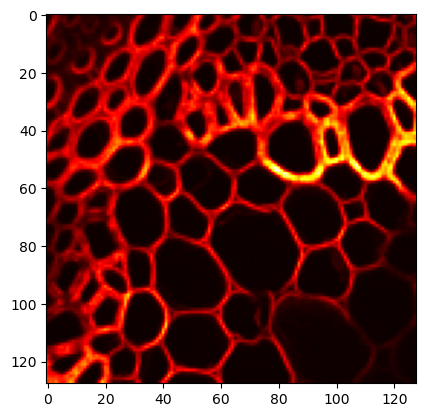

In [376]:
for elem in iter(X_Train_Dataloder):
    element = elem[0][0]
    elem = element.permute(1,2,0)
    elem = elem.cpu().detach().numpy()
    plt.imshow(elem, cmap = "hot")
    break

(array([1.0644e+04, 1.8790e+03, 1.6080e+03, 1.1480e+03, 6.0900e+02,
        2.5800e+02, 1.3800e+02, 6.5000e+01, 2.9000e+01, 6.0000e+00]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

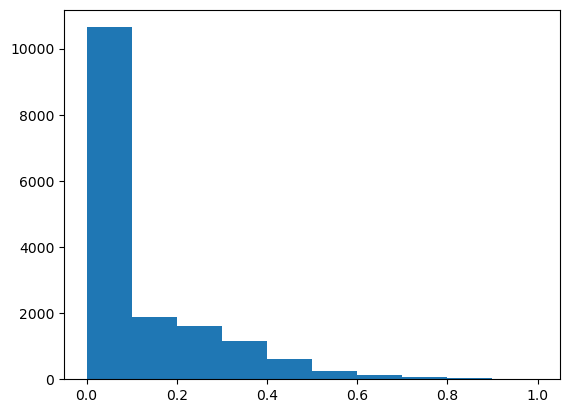

In [377]:
plt.hist(element.detach().cpu().numpy().reshape(-1,))

In [378]:
X_train[0]

array([[0.01173081, 0.01395107, 0.01774019, ..., 0.23841207, 0.14774349,
        0.04392605],
       [0.01500965, 0.01794483, 0.01995659, ..., 0.21888853, 0.18591193,
        0.08734187],
       [0.0216383 , 0.08370034, 0.22475426, ..., 0.19487456, 0.1934648 ,
        0.12476311],
       ...,
       [0.01317754, 0.0079436 , 0.01097131, ..., 0.01234234, 0.01001377,
        0.01147668],
       [0.02070958, 0.00951283, 0.01499486, ..., 0.01205184, 0.0092686 ,
        0.01169089],
       [0.01564637, 0.01144992, 0.01465602, ..., 0.01327336, 0.00606418,
        0.01692378]])

(array([1.0644e+04, 1.8790e+03, 1.6080e+03, 1.1480e+03, 6.0900e+02,
        2.5800e+02, 1.3800e+02, 6.5000e+01, 2.9000e+01, 6.0000e+00]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

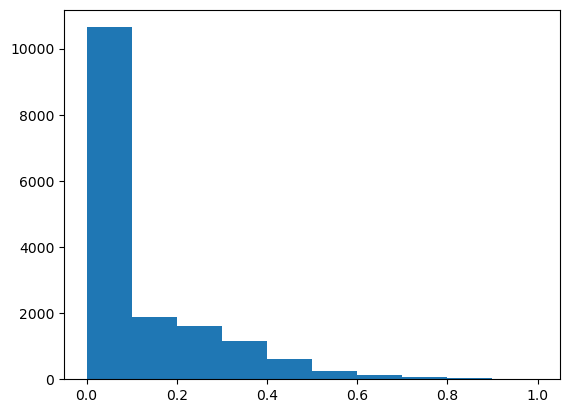

In [379]:
plt.hist(element.detach().cpu().numpy().reshape(-1,))

In [384]:
AE_Model = Convolutional_AE(learning_rate = 1e-3, dropout_rate= 0.15, weight_decay = 1e-5)
AE_Model = AE_Model.to(device)

In [385]:
element = element.view(-1, 1, 128, 128)
element = element.to(device)
element.shape

torch.Size([1, 1, 128, 128])

In [386]:
AE_Model.predict_step((element, element), 1).shape

torch.Size([1, 1, 128, 128])

In [387]:
# Set up the training loop for the model
Early_Stopping = EarlyStopping(monitor = "Validation_Loss", patience = 15, mode = "min")
Model_Checkpoint = ModelCheckpoint(monitor = "Validation_Loss", save_top_k = 1, mode = "min", save_weights_only = True)
Learning_Rate_Monitor = LearningRateMonitor(logging_interval = "step")
Tensorboard_Logger = TensorBoardLogger("Lightning_logs", name = "Possion_AE")
Max_Epochs = 100

name = "Convolutional_Autoencoder"
CHECKPOINT_PATH = './models/'

Trainer = pL.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, name), gradient_clip_val=10,
                     max_epochs=Max_Epochs, accelerator = "gpu", logger=Tensorboard_Logger,
                     callbacks=[Model_Checkpoint,
                                Learning_Rate_Monitor,
                                Early_Stopping])

Trainer.fit(AE_Model, X_Train_Dataloder, X_Valid_Dataloder)
Trainer.save_checkpoint(os.path.join(CHECKPOINT_PATH, name)+'.ckpt')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 1.2 M 
1 | decoder | Decoder | 431 K 
------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.424     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [263]:
Model = AE_Model.load_from_checkpoint(os.path.join(CHECKPOINT_PATH, name)+'.ckpt').to(device)

TypeError: The classmethod `Convolutional_AE.load_from_checkpoint` cannot be called on an instance. Please call it on the class type and make sure the return value is used.

In [396]:
Trainer.test(AE_Model, X_Train_Dataloder)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      Test_Loss_epoch      │   0.0010346703929826617   │
└───────────────────────────┴───────────────────────────┘

[{'Test_Loss_epoch': 0.0010346703929826617}]

In [397]:
Trainer.test(AE_Model, X_Valid_Dataloder)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      Test_Loss_epoch      │   0.0017256244318559766   │
└───────────────────────────┴───────────────────────────┘

[{'Test_Loss_epoch': 0.0017256244318559766}]

In [398]:
element = element.to(device)
AE_Model.to(device)

Convolutional_AE(
  (encoder): Encoder(
    (GaussianNoise): GaussianNoise()
    (conv1a): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1b): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1c): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1))
    (MaxPool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (BatchNorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout(p=0.15, inplace=False)
    (activation): LeakyReLU(negative_slope=0.01)
    (conv2a): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2b): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2c): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (MaxPool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (BatchNorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (d

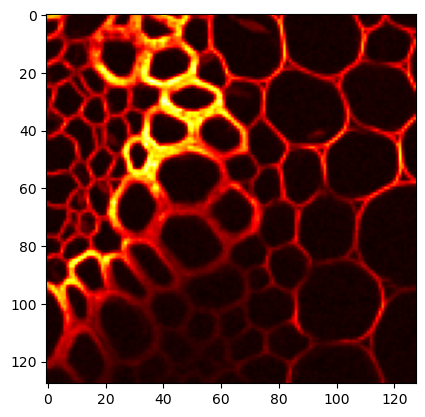

In [431]:
for elem in iter(X_Train_Dataloder):
    element = elem[0][0]
    elem = element.permute(1,2,0)
    elem = elem.cpu().detach().numpy()
    plt.imshow(elem, cmap = "hot")
    break

In [432]:
element = element.view(-1, 1, 128, 128).to(device)
Trial = AE_Model.predict_step((element, element), 1)
Trial.shape

torch.Size([1, 1, 128, 128])

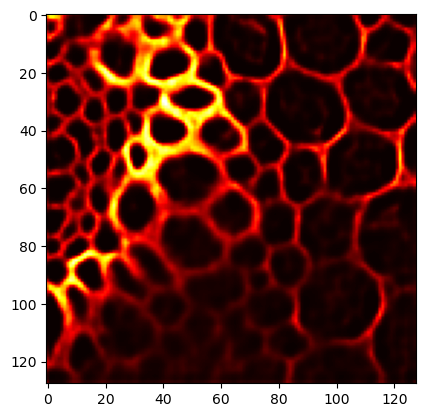

In [433]:
Trialler = Trial.permute(0,2,3,1).detach().cpu().numpy()
Trialler = Trialler[0]
plt.imshow(Trialler, cmap = "hot")